# Student Stress Classification

- **Iteration №: 1**
- **Student: Ivan Bodnar**

During this iteration I have used two datasets:
- an AI generated dataset
- a dataset collected from a survey posted for Fontys University of Applied Science students. The survey was made  the iteration 0

In [211]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import missingno as msno
from pandas.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestClassifier

## Synthetic dataset

In a feedback from one of my teachers I have got a contact of a person who could give me some insights on stress as she has been conducting a stress related project. Apparently she is not an expert in the field and was not conducting any project at the time, but she did give me some advice on how to make a questionnaire and shared some parts of a book about stress "Busy Busy Busy" | Carry Petri, Jolanda Bouman. This book has been containing a "stress resistance test", where some of the questions seemed useful for my questionnaire so I have decided to make a synthetic dataset to work and experiment on, while I am arranging a meeting with universities psychologist.

### Data Provisioning

In [212]:
synthetic_stress = pd.read_csv('synthetic/mnt/student_stress_dataset_2500_balanced.csv')
synthetic_stress.head()

,ID,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,...,clammy_hands,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel
0,1,B,C,A,C,A,C,A,C,A,...,D,D,B,C,D,D,C,C,C,High
1,2,B,A,C,B,B,A,A,A,B,...,C,B,A,C,C,C,B,A,A,Low
2,3,B,B,A,B,C,D,C,B,C,...,D,C,C,D,A,D,D,D,C,High
3,4,D,B,B,A,B,B,B,C,C,...,A,D,B,D,A,B,B,B,D,High
4,5,C,B,D,B,C,B,C,B,C,...,B,C,C,A,C,D,A,D,B,High


I have asked chat gpt to generate a dataset based on the questions I have got from the book:

    - I am never completely satisfied with my achievements
    - I am quickly irritated by other people
    - I am in a hurry to finalize things
    - I am often unsure of myself
    - I often dwell on things that have happened
    - I find it hard to show my emotions
    - The future seems gloomy to me
    - I tend to fret about disappointments
    - I find it hard to distance myself from my work, during my own time
    - I hesitate when making decisions
    - I am easily wound up
    - I often feel lonely
    - The weather affects my mood
    - I am often dissatisfied with my achievements
    - I quickly become impatient
    - I smoke too much
    - I lack confidence
    - I find it hard to think clearly when I am in a difficult situation
    - I often feel rushed in my work 
    - I am not sleeping well
    - I drink more than I should
    - I find it hard to relax
    - I cant concentrate
    - I don't get much exercise
    - I am sensitive to noise
    - I am prone to sudden headaches
    - I often have clammy hands
    - I find criticism difficult and I don't deal with it well
    - I often have panic attacks
    - I distrust people around
    - I have stomachaches and/or intestinal problems
    - I often allow my life to be dictated by other people, or by my environment
    - I am easily distracted, either by people or by events
    - I get frightened easily
    - I am often pushed for time

In [213]:
synthetic_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           2500 non-null   int64 
 1   achievement_satisfaction     2500 non-null   object
 2   irritation                   2500 non-null   object
 3   hurry_to_finalize            2500 non-null   object
 4   self_doubt                   2500 non-null   object
 5   rumination                   2500 non-null   object
 6   emotional_repression         2500 non-null   object
 7   pessimism                    2500 non-null   object
 8   disappointment_fretting      2500 non-null   object
 9   work_detachment              2500 non-null   object
 10  indecisiveness               2500 non-null   object
 11  easily_wound_up              2500 non-null   object
 12  loneliness                   2500 non-null   object
 13  weather_mood                 2500

Each question can have 4 possible answers: A (never), B(sometimes), C(often), D(always)

In [214]:
unique_example = synthetic_stress['achievement_satisfaction'].unique()
print(unique_example)

['B' 'D' 'C' 'A']


In [215]:
synthetic_stress.describe()

,ID
count,2500.00000
mean,1250.50000
std,721.83216
min,1.00000
25%,625.75000
50%,1250.50000
75%,1875.25000
max,2500.00000


StressLevel
Moderate    1766
High         670
Low           64
Name: count, dtype: int64


<Axes: xlabel='StressLevel'>

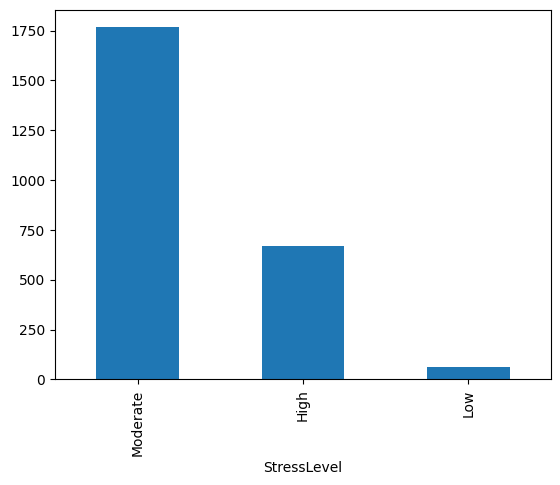

In [216]:
print(synthetic_stress['StressLevel'].value_counts())
synthetic_stress['StressLevel'].value_counts().plot(kind='bar')

The distribution of the target variable classes is not balanced, but when I will work on a real dataset, it might be the same. 

### Preprocessing

Dropping ID column as it is not needed for my case.

In [217]:
synthetic_stress.drop(['ID'], axis=1, inplace=True)
synthetic_stress.sample(5)

,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,indecisiveness,...,clammy_hands,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel
488,D,B,B,A,A,C,B,C,A,A,...,D,B,B,D,D,A,D,C,C,Moderate
1821,B,A,B,B,C,C,B,B,A,C,...,A,B,A,B,B,B,C,B,A,Moderate
1438,C,A,D,C,A,C,A,B,A,D,...,B,B,B,C,A,B,C,A,D,High
615,B,C,C,C,A,B,B,D,C,A,...,A,C,B,B,B,B,B,A,D,Moderate
458,B,C,B,C,B,B,C,A,B,C,...,B,D,A,A,A,C,C,C,C,High


In [218]:
synthetic_features = ['achievement_satisfaction', 'irritation', 'hurry_to_finalize', 'self_doubt', 'rumination', 'emotional_repression', 'pessimism', 'disappointment_fretting', 'work_detachment', 'indecisiveness', 'easily_wound_up', 'loneliness', 'weather_mood', 'achievement_dissatisfaction', 'impatience', 'smoking', 'lack_confidence', 'unclear_thinking', 'rushed_work', 'poor_sleep', 'alcohol', 'relaxation_difficulty', 'poor_concentration', 'lack_exercise', 'noise_sensitivity', 'headaches', 'clammy_hands', 'criticism_sensitivity', 'panic_attacks', 'distrust', 'stomach_issues', 'people_pleasing', 'distractibility', 'easily_frightened', 'time_pressure']

Making values numerical. I figured as my data is categorical, I can just use sklearn OneHotEncoder, to save myself some time as it does the same thing, but I leave this for future improvement

In [219]:
synthetic_stress["achievement_satisfaction"] = synthetic_stress["achievement_satisfaction"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["irritation"] = synthetic_stress["irritation"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["hurry_to_finalize"] = synthetic_stress["hurry_to_finalize"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["self_doubt"] = synthetic_stress["self_doubt"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["rumination"] = synthetic_stress["rumination"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["emotional_repression"] = synthetic_stress["emotional_repression"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["pessimism"] = synthetic_stress["pessimism"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["disappointment_fretting"] = synthetic_stress["disappointment_fretting"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["work_detachment"] = synthetic_stress["work_detachment"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["indecisiveness"] = synthetic_stress["indecisiveness"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["easily_wound_up"] = synthetic_stress["easily_wound_up"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["loneliness"] = synthetic_stress["loneliness"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["weather_mood"] = synthetic_stress["weather_mood"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["achievement_dissatisfaction"] = synthetic_stress["achievement_dissatisfaction"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["impatience"] = synthetic_stress["impatience"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["smoking"] = synthetic_stress["smoking"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["lack_confidence"] = synthetic_stress["lack_confidence"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["unclear_thinking"] = synthetic_stress["unclear_thinking"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["rushed_work"] = synthetic_stress["rushed_work"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["poor_sleep"] = synthetic_stress["poor_sleep"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["alcohol"] = synthetic_stress["alcohol"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["relaxation_difficulty"] = synthetic_stress["relaxation_difficulty"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["poor_concentration"] = synthetic_stress["poor_concentration"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["lack_exercise"] = synthetic_stress["lack_exercise"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["noise_sensitivity"] = synthetic_stress["noise_sensitivity"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["headaches"] = synthetic_stress["headaches"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["clammy_hands"] = synthetic_stress["clammy_hands"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["criticism_sensitivity"] = synthetic_stress["criticism_sensitivity"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["panic_attacks"] = synthetic_stress["panic_attacks"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["distrust"] = synthetic_stress["distrust"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["stomach_issues"] = synthetic_stress["stomach_issues"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["people_pleasing"] = synthetic_stress["people_pleasing"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["distractibility"] = synthetic_stress["distractibility"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["easily_frightened"] = synthetic_stress["easily_frightened"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["time_pressure"] = synthetic_stress["time_pressure"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)

synthetic_stress["StressLevel"] = synthetic_stress["StressLevel"].map({'Low':0, 'Moderate':1, 'High':2}).astype(int)

I have modified the heatmap a bit so it covers all features and is not a huge mess at the same time

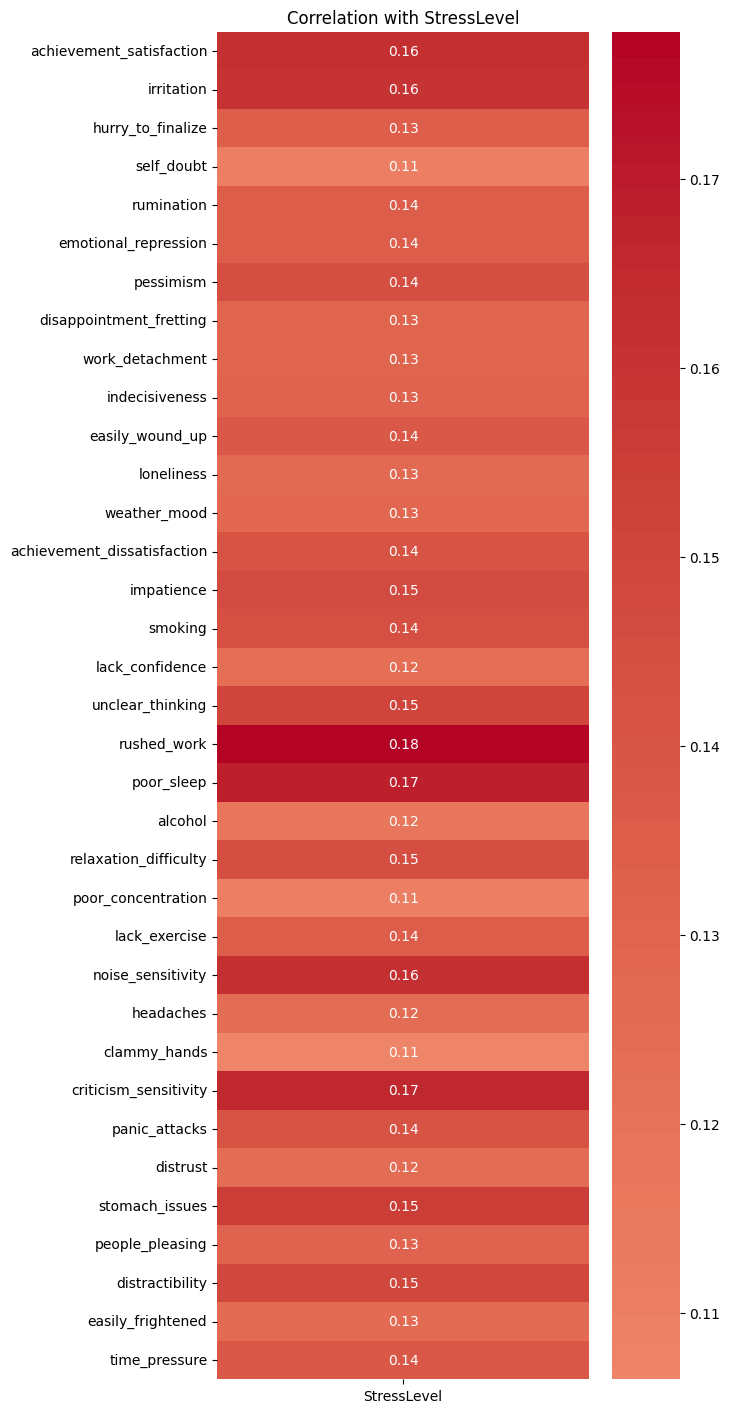

In [220]:
correlation_matrix = synthetic_stress.corr()
stress_corr = correlation_matrix[['StressLevel']].drop('StressLevel')
plt.figure(figsize=(6, len(stress_corr) * 0.5)) 
sns.heatmap(stress_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation with StressLevel')
plt.show()

The problem with such data is that the relation between categorical features and categorical target variable is that its hard to see using normal pairplot or heatmap, so I wil try to use approaches I have found on the internet for such case 

To save space I will perform the tests only on those features that have stronger correlation (heatmap)

First thing I will try is to use boxplot, to see which categories of a feature relate to specific categories 

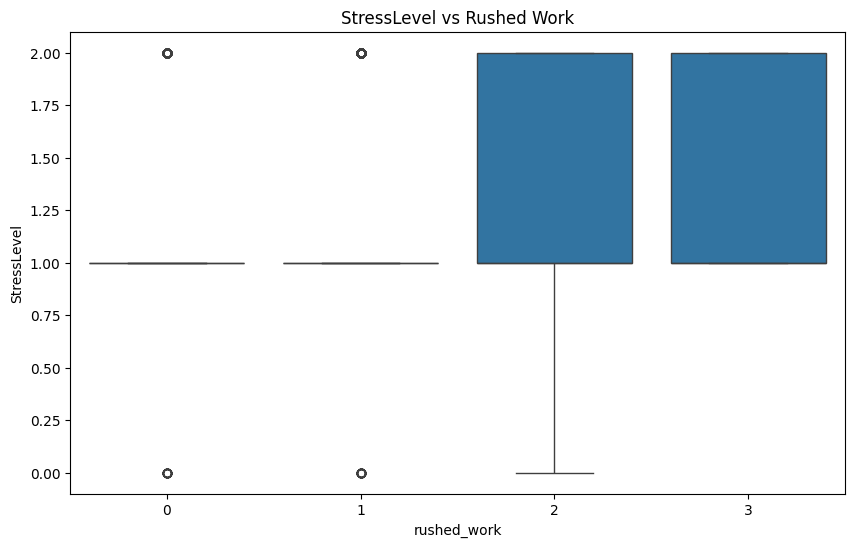

In [221]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=synthetic_stress, x='rushed_work', y='StressLevel')
plt.title('StressLevel vs Rushed Work')
plt.show()

From here it can be seen that the values of rushed work 2 and 3 (which is C(often), D(always)), have high density in categories 1 and 2 of the target variable (). Another thing I can pin point is the outliers in rushed_work 0 and 1 in category 2 of the StressLevel. I will cover this in the conclusion.

The second approach I have found is a crossatab. It shows pretty muc the same thing as the boxplot but in numeric view

In [222]:
contingency = pd.crosstab(synthetic_stress['achievement_satisfaction'], synthetic_stress['StressLevel'])
print(contingency)

StressLevel                0    1    2
achievement_satisfaction              
0                         28  461  102
1                         17  626  222
2                         15  448  196
3                          4  231  150


Third approach I have found is a chi-square test. 

In [223]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab(synthetic_stress['irritation'], synthetic_stress['StressLevel'])
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square = {chi2:.2f}, p-value = {p:.4f}")

Chi-square = 73.55, p-value = 0.0000


There is one more indicator but I will come to it in the evaluation part

#### Feature Selection

I will keep all the features, as the last thing that is nice to see is the feature importances in the tree model 

In [224]:
X_synthetic_stress = synthetic_stress[['achievement_satisfaction', 'irritation', 'hurry_to_finalize', 'self_doubt', 'rumination', 'emotional_repression', 'pessimism', 'disappointment_fretting', 'work_detachment', 'indecisiveness', 'easily_wound_up', 'loneliness', 'weather_mood', 'achievement_dissatisfaction', 'impatience', 'smoking', 'lack_confidence', 'unclear_thinking', 'rushed_work', 'poor_sleep', 'alcohol', 'relaxation_difficulty', 'poor_concentration', 'lack_exercise', 'noise_sensitivity', 'headaches', 'clammy_hands', 'criticism_sensitivity', 'panic_attacks', 'distrust', 'stomach_issues', 'people_pleasing', 'distractibility', 'easily_frightened', 'time_pressure']]
y_synthetic_stress = synthetic_stress['StressLevel']

#### Train test split

In [225]:
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X_synthetic_stress, y_synthetic_stress)
X_train, X_test, y_train, y_test = train_test_split(X_synthetic_stress, y_synthetic_stress, test_size=.2)
print("There are in total", len(X_synthetic_stress), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 2500 observations, of which 2000 are now in the train set, and 500 in the test set.


### Random Forest 

#### Modeling

In [226]:
# from statistics import mean

# lst_accu_stratified = []
# all_y_true = []
# all_y_pred = []
# model = RandomForestClassifier()

# for train_index, test_index in skf.split(X_synthetic_stress, y_synthetic_stress):
#     X_train, X_test = X_synthetic_stress.iloc[train_index], X_synthetic_stress.iloc[test_index]
#     y_train, y_test = y_synthetic_stress.iloc[train_index], y_synthetic_stress.iloc[test_index]

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     lst_accu_stratified.append(model.score(X_test, y_test))

#     all_y_true.extend(y_test)
#     all_y_pred.extend(y_pred)

# print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
# print("\nAggregated Classification Report (all folds):")
# print(classification_report(all_y_true, all_y_pred))

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)


0.736

The models accuracy has reached 75% which is relatively good, and can identify that the ways of seeing relations may be working

#### Evaluation

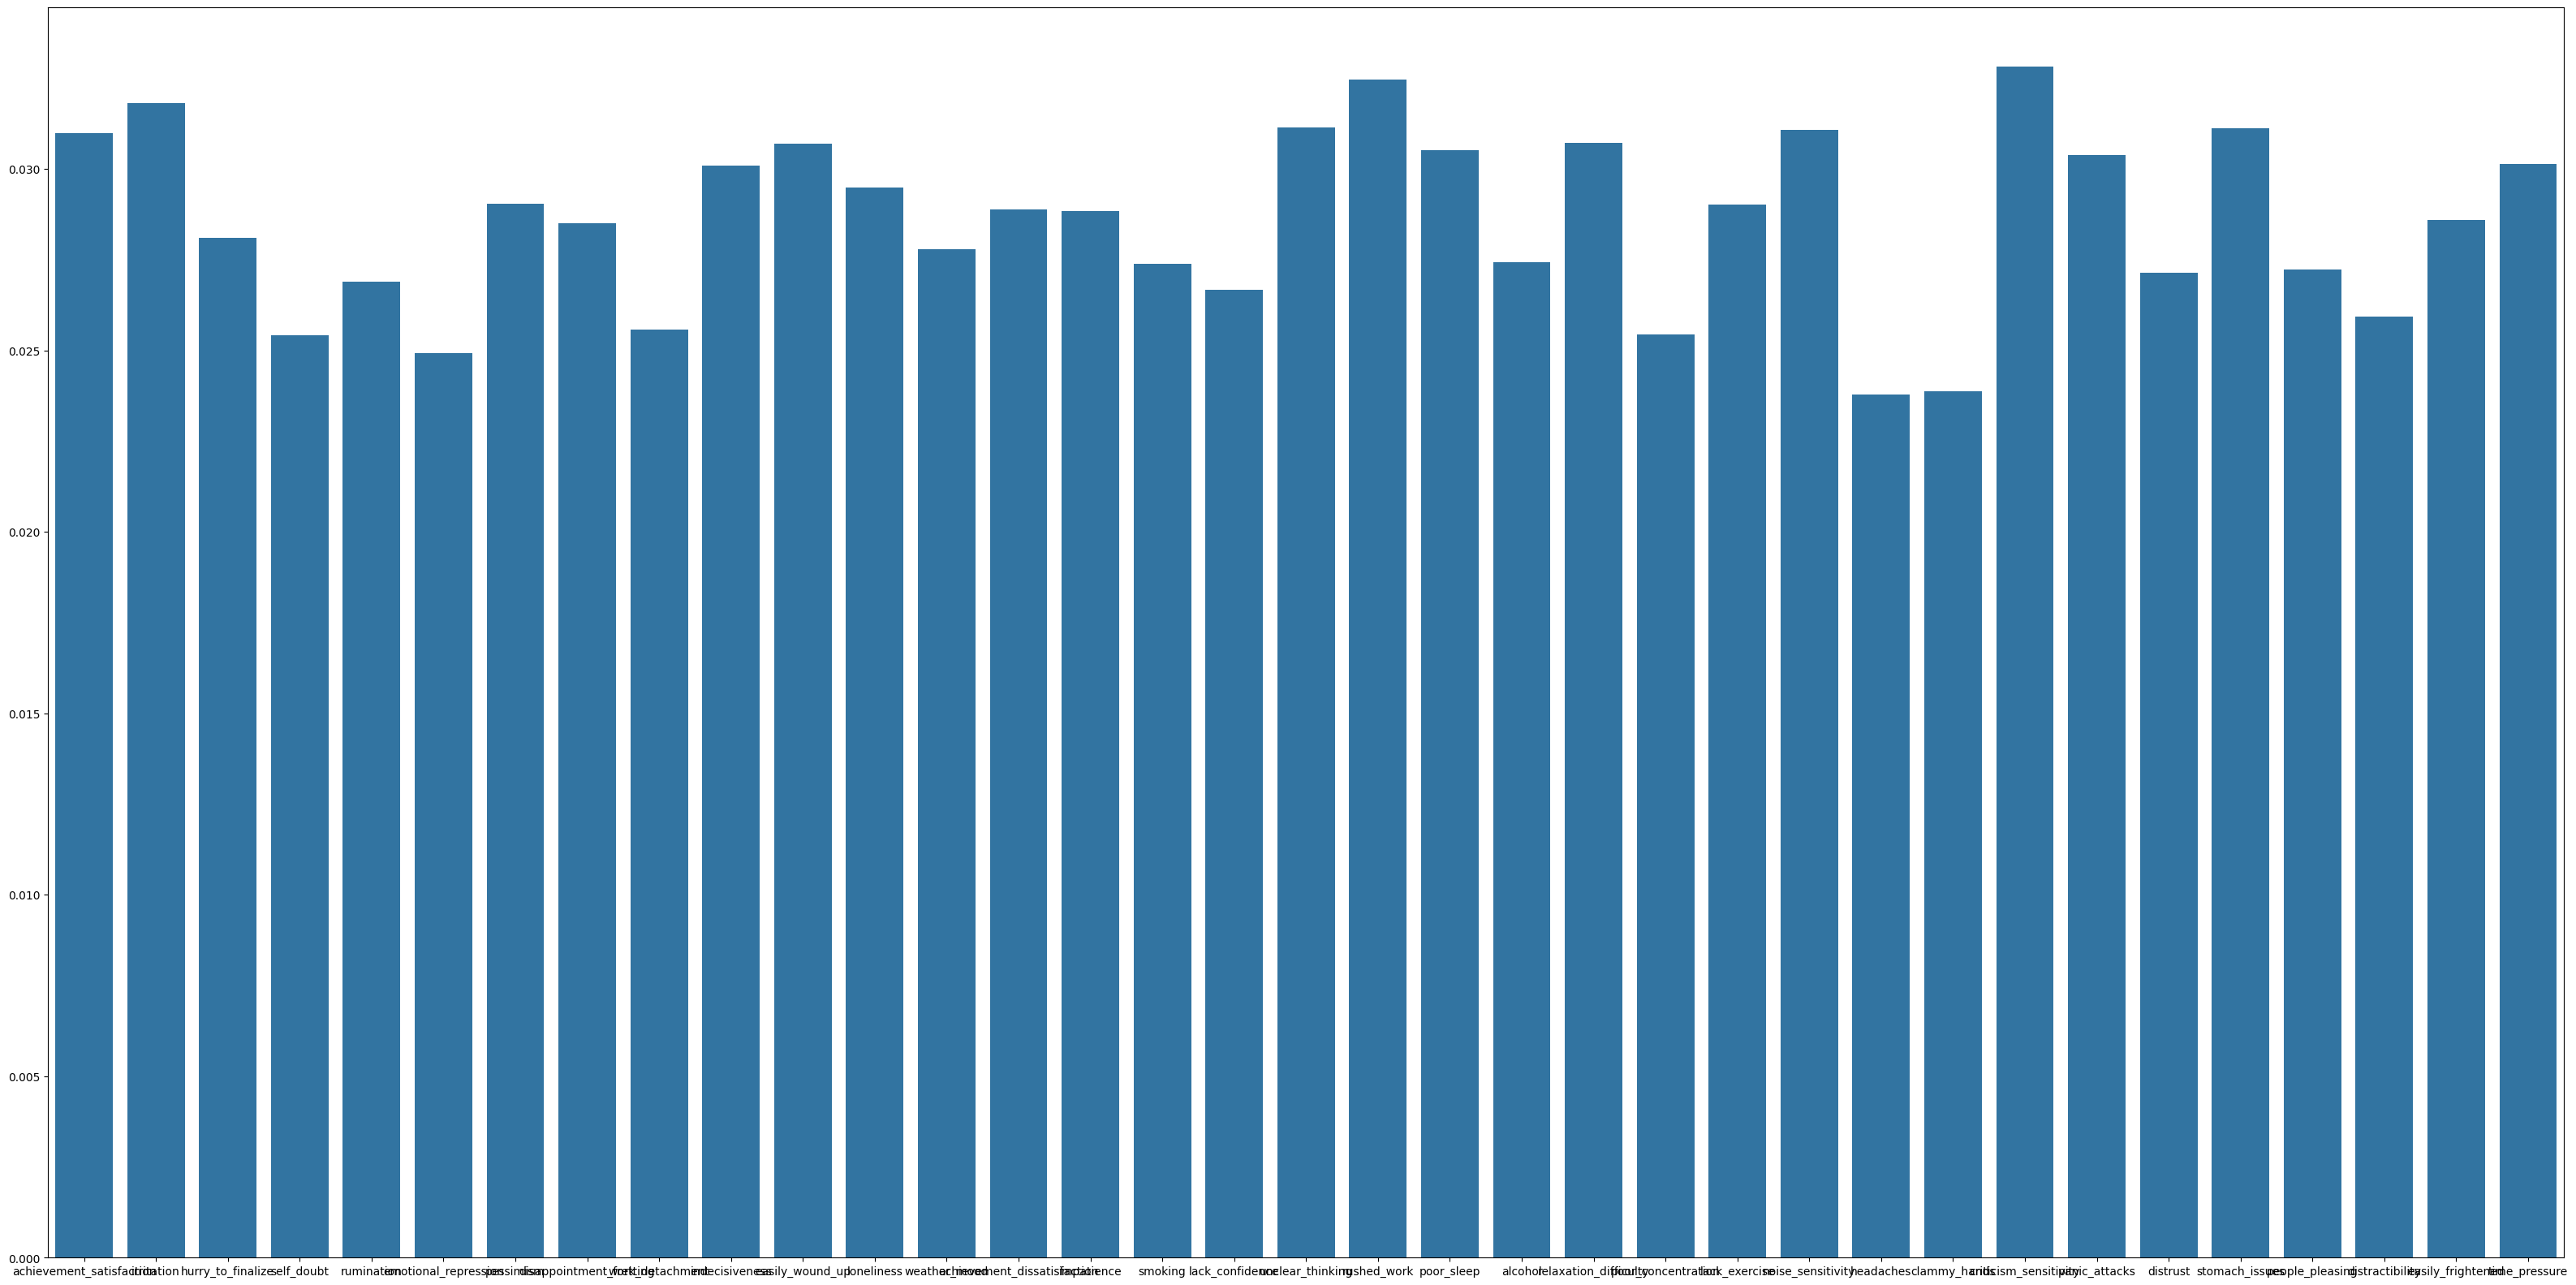

In [227]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=model.feature_importances_, x=synthetic_features)
plt.show()

As I have mentioned in the Preprocessing part, the last thing we can see when it comes to relation between the features and the target variable is the feature importance in a tree-like models. In the plot above it can be seen that each feature has played an important part in the decision, which is very good.

### Clustering

One thing that is nice to see is how does the clustering work in my project

#### Modeling 

From some experiments with the Agglomerative Clustering, one thing that I have to tune is the number of clusters, as without this parameter the model founds 370 clusters, which is completely off.

In [228]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(n_clusters=3, compute_distances=True)
agglom.fit(X_synthetic_stress)

print('Number of clusters: ',agglom.n_clusters_)

Number of clusters:  3


In [229]:
print(np.unique(agglom.labels_))

[0 1 2]


In [230]:
print(agglom.n_leaves_)

2500


#### Evaluation

I have taken the code for plotting the dendogram from the Clustering exercise. It shows how the clusters were made 

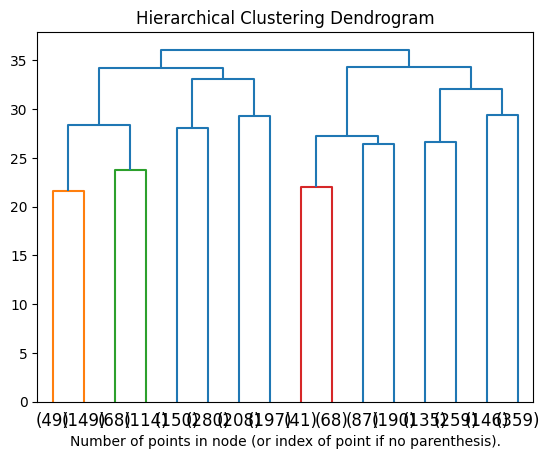

In [231]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglom, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [232]:
synthetic_stress['Cluster'] = agglom.labels_.astype(str)
synthetic_stress['Cluster'] = 'Cluster ' + synthetic_stress['Cluster']
synthetic_stress.head(5)

,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,indecisiveness,...,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel,Cluster
0,1,2,0,2,0,2,0,2,0,0,...,3,1,2,3,3,2,2,2,2,Cluster 1
1,1,0,2,1,1,0,0,0,1,0,...,1,0,2,2,2,1,0,0,0,Cluster 0
2,1,1,0,1,2,3,2,1,2,2,...,2,2,3,0,3,3,3,2,2,Cluster 0
3,3,1,1,0,1,1,1,2,2,2,...,3,1,3,0,1,1,1,3,2,Cluster 1
4,2,1,3,1,2,1,2,1,2,2,...,2,2,0,2,3,0,3,1,2,Cluster 1


In [233]:
synthetic_stress.tail(5)

,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,indecisiveness,...,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel,Cluster
2495,1,3,0,1,3,0,1,2,2,2,...,1,3,1,0,0,1,1,1,1,Cluster 1
2496,0,0,1,1,0,3,0,2,1,0,...,3,0,0,1,3,3,3,1,1,Cluster 1
2497,1,3,2,2,3,1,0,2,0,1,...,1,2,0,2,0,2,1,2,1,Cluster 0
2498,3,3,2,0,0,0,0,1,2,1,...,2,2,1,2,3,1,0,1,2,Cluster 0
2499,2,3,3,2,1,1,1,3,1,2,...,0,3,3,1,3,2,3,2,2,Cluster 0


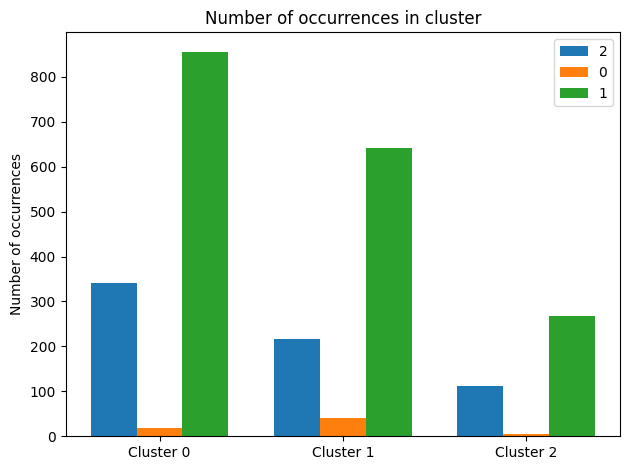

In [234]:
# Define labels for species
species = synthetic_stress['StressLevel'].unique()

# Define labels for clusters
clusters = synthetic_stress['Cluster'].unique()

# Sort cluster names in alphabetical order, i.e.,
# Cluster 0, Cluster 1, Cluster 2, etc.
clusters.sort()

# Determine the location for cluster labels 
x = np.arange(len(clusters))

# Define the width of the bars
width = 0.25

# Create the bar plot
fig, ax = plt.subplots()
offset = -width
for spec in species:
    nr_occurrences = []
    for clus in clusters:
        nr = synthetic_stress[(synthetic_stress['StressLevel']==spec) & (synthetic_stress['Cluster']==clus)]['Cluster'].count()
        nr_occurrences.append(nr)
    rects = ax.bar(x + offset, nr_occurrences, width, label=spec)
    offset = offset + width

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of occurrences')
ax.set_title('Number of occurrences in cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

fig.tight_layout()
plt.show()

In [235]:
print(synthetic_stress['StressLevel'].value_counts())
print(synthetic_stress['Cluster'].value_counts())

levels = synthetic_stress['StressLevel'].unique()
for level in levels:
    print('Number of samples per cluster for',spec)
    print(synthetic_stress[synthetic_stress['StressLevel']==spec]['Cluster'].value_counts())

StressLevel
1    1766
2     670
0      64
Name: count, dtype: int64
Cluster
Cluster 0    1215
Cluster 1     899
Cluster 2     386
Name: count, dtype: int64
Number of samples per cluster for 1
Cluster
Cluster 0    856
Cluster 1    642
Cluster 2    268
Name: count, dtype: int64
Number of samples per cluster for 1
Cluster
Cluster 0    856
Cluster 1    642
Cluster 2    268
Name: count, dtype: int64
Number of samples per cluster for 1
Cluster
Cluster 0    856
Cluster 1    642
Cluster 2    268
Name: count, dtype: int64


### Decision Tree Classifier

#### Modeling

In [236]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.674


#### Evaluation

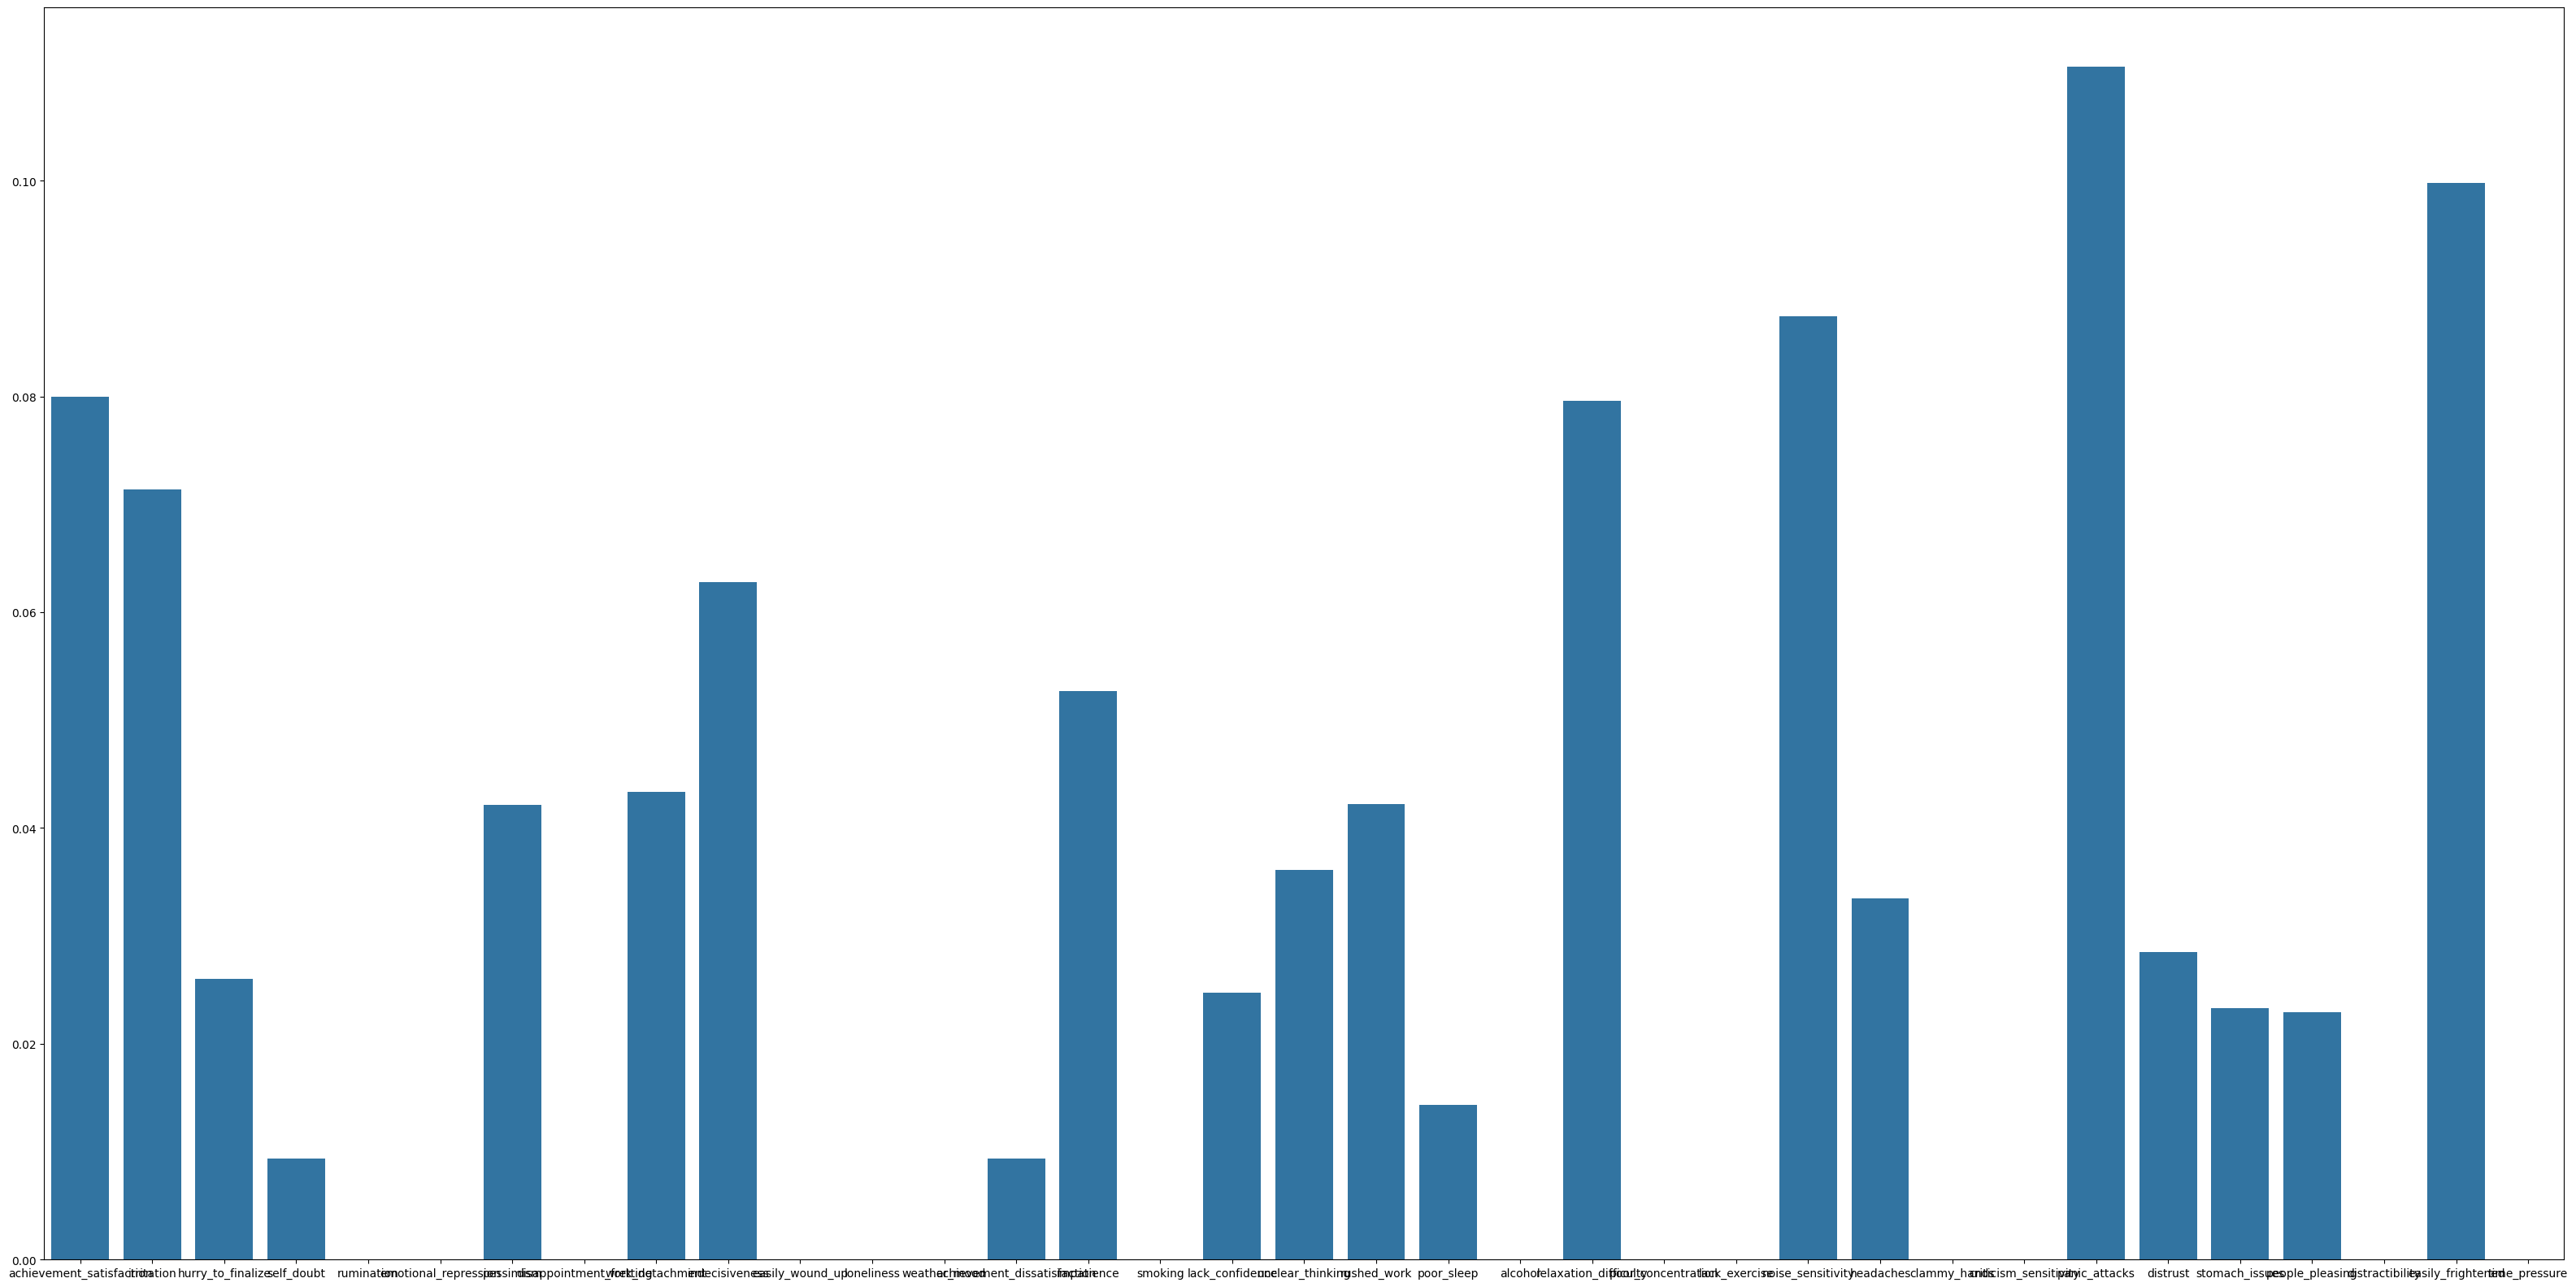

In [237]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=model.feature_importances_, x=synthetic_features)
plt.show()

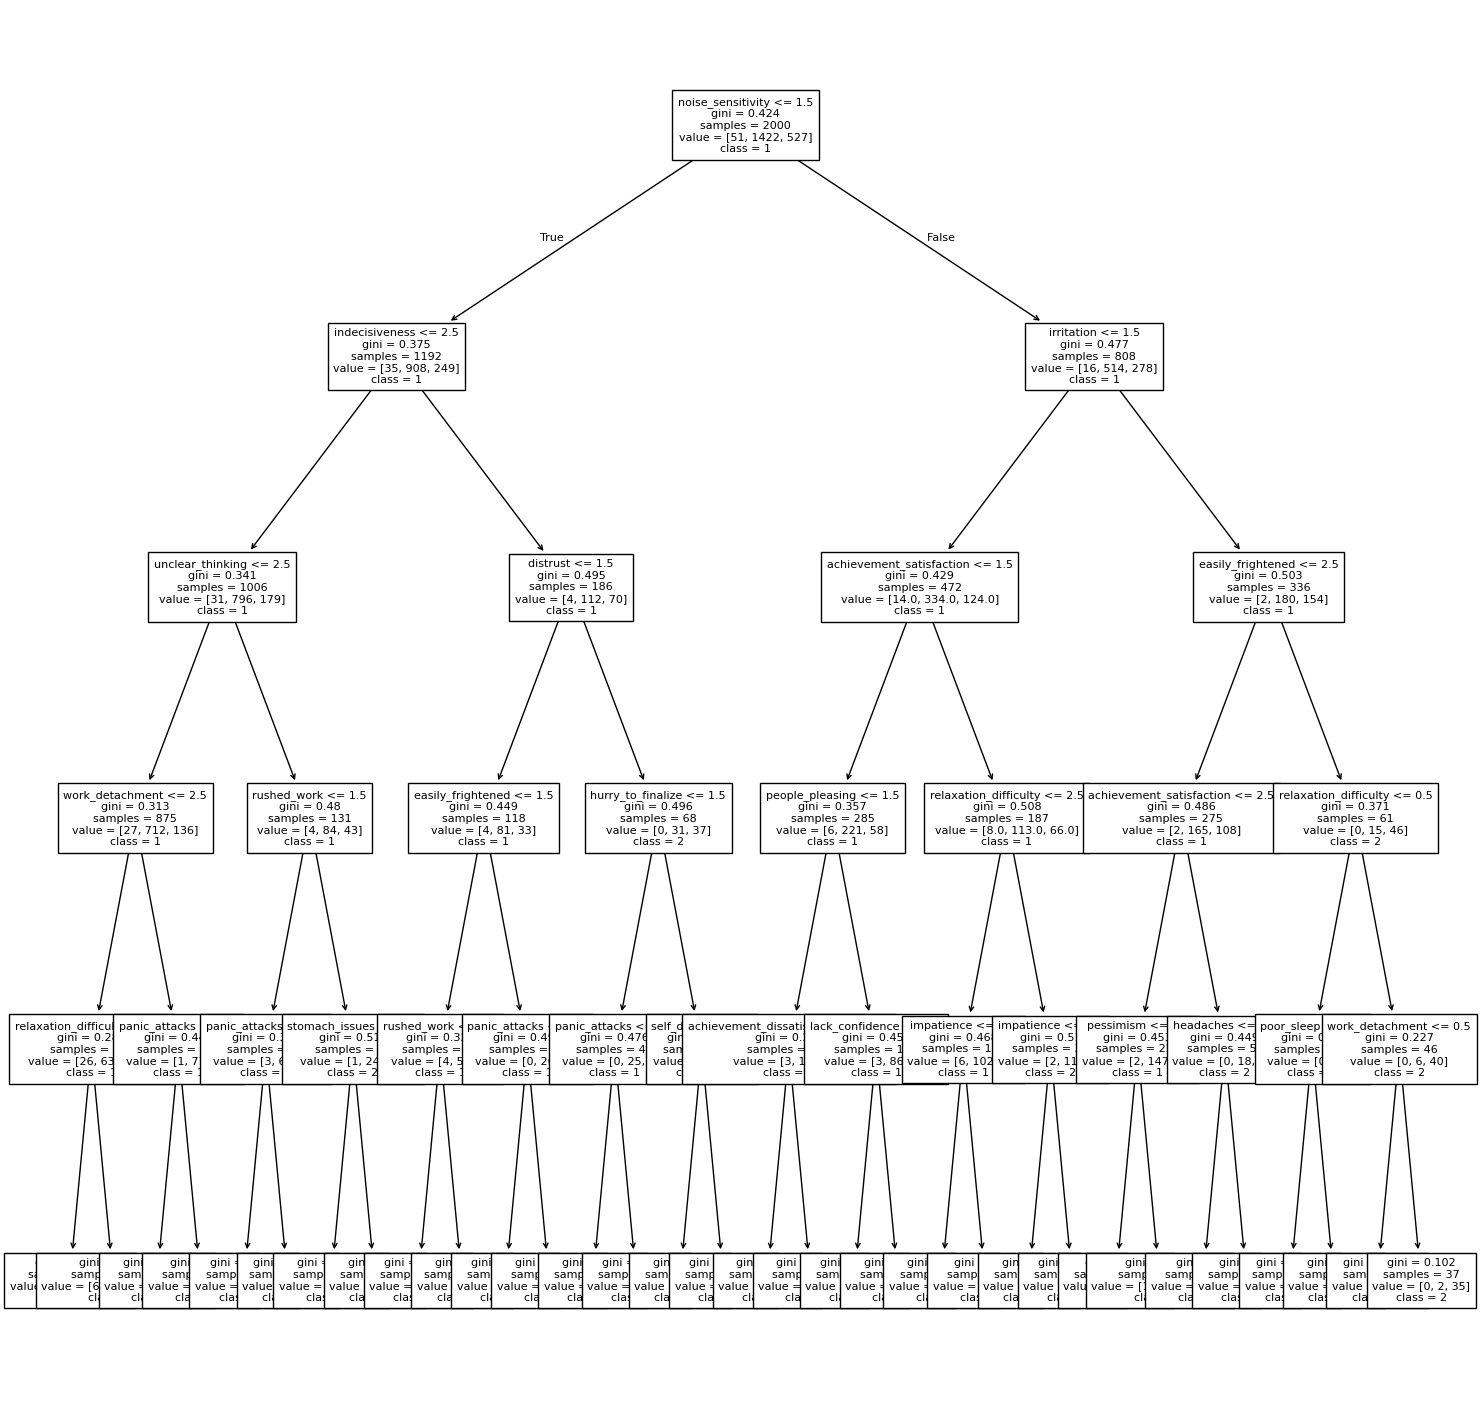

In [238]:
target_names = ["0", "1", "2"]
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
from sklearn.tree import plot_tree
plot_tree(model, fontsize=8, feature_names=synthetic_features, class_names=target_names)
plt.show()

In [239]:
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.71      0.89      0.79       344
           2       0.45      0.22      0.30       143

    accuracy                           0.67       500
   macro avg       0.39      0.37      0.36       500
weighted avg       0.62      0.67      0.63       500



c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### Inference

## Fontys Student Stress Survey

From my iteration 0 and Synthetic Dataset part I have made a google form and posted it to Fontys students: https://docs.google.com/forms/d/e/1FAIpQLSe1NUOqiga-TfrjSjefwqrSNO9Jr5bqO_mSAaaqc8q0OSme9g/viewform?usp=sharing

The form is connected to a google sheet, from where I will get the data

### Data Provisioning

In order to get the data from google sheets to python I have followed a video on youtube (https://www.youtube.com/watch?v=hyUw-koO2DA)

In [240]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# define the scope and credentials
scopes = ['https://www.googleapis.com/auth/spreadsheets.readonly', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('google-sheets-access/student-stress-457900-e232b54e76fb.json', scopes=scopes)

# authorize and open the workbook
file = gspread.authorize(creds)
workbook = file.open('fontys_student_stress')
sheet = workbook.worksheet('stress')

# get all records from the sheet and convert to a pandas DataFrame
data = sheet.get_all_records()
df = pd.DataFrame(data)

print(df)

         Позначка часу  \
0  25.04.2025 03:11:16   
1  25.04.2025 03:41:40   

   How much time do you spend on studying daily? (in hours)  \
0                                           2.333333          
1                                           6.000000          

  Would you like to pursue a career based on your profile/specialization?  \
0                                               100%                        
1                                               100%                        

  Do you have a part time job?  How many hours do you usually sleep?  \
0                          Yes                                     6   
1                          Yes                                     5   

  How would you describe your diet?  \
0                           Average   
1                           Healthy   

   How much time do you spend on physical activities daily (general exercises, any sport counts)?  \
0                                                  2           

In [241]:
df.to_csv('survey/fontys-student-stress-survey.csv', index=False)
fontys_stress = pd.read_csv('survey/fontys-student-stress-survey.csv')
fontys_stress.head()

,Позначка часу,How much time do you spend on studying daily? (in hours),Would you like to pursue a career based on your profile/specialization?,Do you have a part time job?,How many hours do you usually sleep?,How would you describe your diet?,"How much time do you spend on physical activities daily (general exercises, any sport counts)?",How often have you felt upset due to something that happened in your academic affairs?,How often you felt as if you were unable to control important things in your academic affairs?,How often you felt nervous and stressed because of academic pressure?,...,I have stomachaches and/or intestinal problems,Have you moved your house in the past 6 month?,Have you had any changes in your lifestyle recently?,Have you had any financial problems lately?,Have you had any sexual problems lately?,Have any of your fellow people been sick (family member or relative) lately?,Have you experienced any injury or sickness lately?,Have you been separated from your family/partner?,"Have you experienced a death of a fellow person (close relative, partner, friend)?","Overall, how would you describe your stress level?"
0,25.04.2025 03:11:16,2.333333,100%,Yes,6,Average,2,Very often,Fairly often,Fairly often,...,Never,No,Yes,No,No,No,Yes,Yes,Yes,High stress
1,25.04.2025 03:41:40,6.000000,100%,Yes,5,Healthy,2,Sometimes,Sometimes,Very often,...,Never,No,Yes,No,No,No,No,Yes,Yes,Moderate stress


This isn't a step of data provisioning but I will rename the columns now for better readability of the dataset

In [242]:
# i have a ukrainian google account, the google form interface is in ukrainian, so the timestamp column is named in ukranian, my bad(
fontys_stress.drop(['Позначка часу'], axis=1, inplace=True)

# renaming columns
fontys_stress.rename(columns={"How much time do you spend on studying daily? (in hours)" : "time-studying"}, inplace=True)
fontys_stress.rename(columns={"How much time do you spend on studying daily? (in hours)" : "time-studying"}, inplace=True)
fontys_stress.rename(columns={"Would you like to pursue a career based on your profile/specialization?" : "career_pursue"}, inplace=True)
fontys_stress.rename(columns={"Do you have a part time job?" : "part_time_job"}, inplace=True)
fontys_stress.rename(columns={"How many hours do you usually sleep?" : "time-sleep"}, inplace=True)
fontys_stress.rename(columns={"How would you describe your diet?" : "diet"}, inplace=True)
fontys_stress.rename(columns={"How much time do you spend on physical activities daily (general exercises, any sport counts)?" : "time-physical-activities"}, inplace=True)
fontys_stress.rename(columns={"How often have you felt upset due to something that happened in your academic affairs?" : "upset_academic_affairs"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if you were unable to control important things in your academic affairs?" : "unable_control_academic_affairs"}, inplace=True)
fontys_stress.rename(columns={"How often you felt nervous and stressed because of academic pressure?" : "nervous_academic_pressure"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if you could not cope with all the mandatory academic activities? (assignments, project requirements, etc.)" : "unable_cope_academic_activities"}, inplace=True)
fontys_stress.rename(columns={"How often you felt confident about your ability to handle your academic / university problems?" : "confident_handle_academic_problems"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if things in your academic life is going on your way?" : "things_going_on_way"}, inplace=True)
fontys_stress.rename(columns={"How often are you able to control irritations in your academic / university affairs?" : "control_irritations_academic_affairs"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if your academic performance was on top?" : "academic_performance_top"}, inplace=True)
fontys_stress.rename(columns={"How often you got angered due to bad performance or low grades that is beyond your control?" : "angered_bad_performance"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if academic difficulties are piling up so high that you could not overcome them?" : "academic_difficulties_piling_up"}, inplace=True)
fontys_stress.rename(columns={"I am never completely satisfied with my achievements" : "never_satisfied_achievements"}, inplace=True)
fontys_stress.rename(columns={"I am quickly irritated by other people" : "quickly_irritated_people"}, inplace=True)
fontys_stress.rename(columns={"The future seems gloomy to me" : "future_gloomy"}, inplace=True)
fontys_stress.rename(columns={"I quickly become impatient" : "quickly_impatient"}, inplace=True)
fontys_stress.rename(columns={"I smoke too much" : "smoke_too_much"}, inplace=True)
fontys_stress.rename(columns={"I find it hard to think clearly when I am in a difficult situation" : "hard_think_clearly"}, inplace=True)
fontys_stress.rename(columns={"I often feel rushed in my work" : "often_rushed_work"}, inplace=True)
fontys_stress.rename(columns={"I am not sleeping well" : "not_sleeping_well"}, inplace=True)
fontys_stress.rename(columns={"I am sensitive to noise" : "sensitive_noise"}, inplace=True)
fontys_stress.rename(columns={"I find criticism difficult and I don't deal with it well" : "find_criticism_difficult"}, inplace=True)
fontys_stress.rename(columns={"I often have panic attacks" : "panic_attacks"}, inplace=True)
fontys_stress.rename(columns={"I have stomachaches and/or intestinal problems" : "stomachaches"}, inplace=True)
fontys_stress.rename(columns={"Have you moved your house in the past 6 month?" : "moved_house"}, inplace=True)
fontys_stress.rename(columns={"Have you had any changes in your lifestyle recently?" : "changes_lifestyle"}, inplace=True)
fontys_stress.rename(columns={"Have you had any financial problems lately?" : "financial_problems"}, inplace=True)
fontys_stress.rename(columns={"Have you had any sexual problems lately?" : "sexual_problems"}, inplace=True)
fontys_stress.rename(columns={"Have any of your fellow people been sick (family member or relative) lately?" : "fellow_people_sick"}, inplace=True)
fontys_stress.rename(columns={"Have you experienced any injury or sickness lately?" : "experienced_injury"}, inplace=True)
fontys_stress.rename(columns={"Have you been separated from your family/partner?" : "separated_family"}, inplace=True)
fontys_stress.rename(columns={"Have you experienced a death of a fellow person (close relative, partner, friend)?" : "experienced_death"}, inplace=True)
fontys_stress.rename(columns={"Overall, how would you describe your stress level?" : "stress_level"}, inplace=True)

fontys_stress.head(5)


,time-studying,career_pursue,part_time_job,time-sleep,diet,time-physical-activities,upset_academic_affairs,unable_control_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,...,stomachaches,moved_house,changes_lifestyle,financial_problems,sexual_problems,fellow_people_sick,experienced_injury,separated_family,experienced_death,stress_level
0,2.333333,100%,Yes,6,Average,2,Very often,Fairly often,Fairly often,Fairly often,...,Never,No,Yes,No,No,No,Yes,Yes,Yes,High stress
1,6.000000,100%,Yes,5,Healthy,2,Sometimes,Sometimes,Very often,Sometimes,...,Never,No,Yes,No,No,No,No,Yes,Yes,Moderate stress


In [243]:
fontys_stress.to_csv('survey/fontys-student-stress-survey.csv', index=False)

In [244]:
fontys_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   time-studying                         2 non-null      float64
 1   career_pursue                         2 non-null      object 
 2   part_time_job                         2 non-null      object 
 3   time-sleep                            2 non-null      int64  
 4   diet                                  2 non-null      object 
 5   time-physical-activities              2 non-null      int64  
 6   upset_academic_affairs                2 non-null      object 
 7   unable_control_academic_affairs       2 non-null      object 
 8   nervous_academic_pressure             2 non-null      object 
 9   unable_cope_academic_activities       2 non-null      object 
 10  confident_handle_academic_problems    2 non-null      object 
 11  things_going_on_way    

In [245]:
fontys_stress.describe()

,time-studying,time-sleep,time-physical-activities
count,2.000000,2.000000,2.0
mean,4.166667,5.500000,2.0
std,2.592725,0.707107,0.0
min,2.333333,5.000000,2.0
25%,3.250000,5.250000,2.0
50%,4.166667,5.500000,2.0
75%,5.083333,5.750000,2.0
max,6.000000,6.000000,2.0


stress_level
High stress        1
Moderate stress    1
Name: count, dtype: int64


<Axes: xlabel='stress_level'>

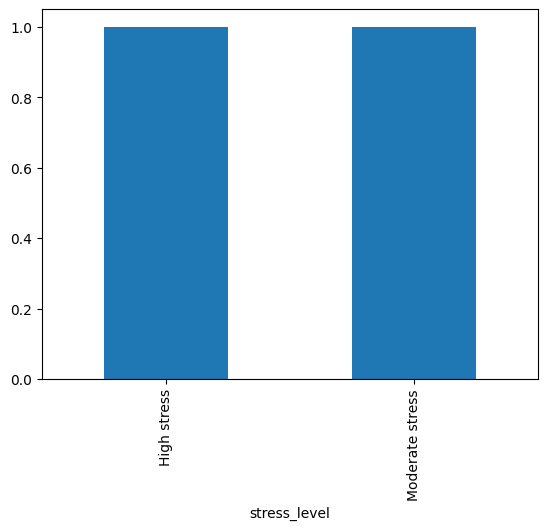

In [246]:
print(fontys_stress['stress_level'].value_counts())
fontys_stress['stress_level'].value_counts().plot(kind='bar')